In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

# loading libraries 

In [3]:
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import timeit
import quilt
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import linear_model
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn import neighbors
from matplotlib.pyplot import figure
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import neighbors, metrics
from sklearn import model_selection
from sklearn import ensemble
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor

# loading data

In [4]:
train_df = pd.read_csv('C:\\Ali\\P08\\train.csv', index_col=0)
test_df = pd.read_csv('C:\\Ali\\P08\\test.csv', index_col=0)
val_type_df = pd.read_csv('C:\\Ali\\P08\\type_var.csv', sep=',')

# Data cleaning an preprocessing

In [5]:
def miss_values(data_df):
    columns = ['colonne', 'nb_val_manquante']
    index = [x for x in range(0, data_df.shape[1])]
    df_ = pd.DataFrame(index=index, columns=columns)
    df_ = df_.fillna(0)
    i = -1
    for col in data_df.columns:
        i = i + 1
        count = data_df[col].isna().sum()
        df_.iloc[i, 0] = col
        df_.iloc[i, 1] = count/data_df.shape[0]*100
    sorted_df = df_.sort_values(by='nb_val_manquante')
    sorted_df.reindex(index, fill_value=0)
    return sorted_df

## data cleanin by variable type

## quant data 

In [6]:
quant_vars = val_type_df[val_type_df['TYPE'] == "QT"]
data_sample_1 = train_df[quant_vars.VAR.values]
df_temp = miss_values(data_sample_1)
data_sample_1 = data_sample_1[
    df_temp[df_temp['nb_val_manquante'] == 0.0]['colonne']]
print(data_sample_1.shape)
print(data_sample_1.columns)

(1460, 29)
Index(['FullBath', 'PoolArea', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch',
       'OpenPorchSF', 'WoodDeckSF', 'GarageArea', 'GarageCars', 'Fireplaces',
       'TotRmsAbvGrd', 'KitchenAbvGr', 'BedroomAbvGr', 'HalfBath', 'MiscVal',
       'YrSold', 'BsmtFullBath', 'GrLivArea', 'LowQualFinSF', '2ndFlrSF',
       '1stFlrSF', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1',
       'YearRemodAdd', 'YearBuilt', 'LotArea', 'BsmtHalfBath'],
      dtype='object')


## qual data 

In [7]:
def preprocess_qual_var(df, columns):
    for col in df.columns:
        if col in columns:
            df.loc[df[col] == 'Po', col] = 1
            df.loc[df[col] == 'Fa', col] = 2
            df.loc[df[col] == 'TA', col] = 3
            df.loc[df[col] == 'Gd', col] = 4
            df.loc[df[col] == 'Ex', col] = 5
    return df

In [8]:
qual_vars = val_type_df[val_type_df['TYPE'] == "QL"]
data_sample_2 = train_df[qual_vars.VAR.values]
df_temp = miss_values(data_sample_2)
data_sample_2 = data_sample_2[
    df_temp[df_temp['nb_val_manquante'] == 0.0]['colonne']]
print(data_sample_2.shape)
print(data_sample_2.columns)

(1460, 7)
Index(['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'HeatingQC',
       'KitchenQual', 'MoSold'],
      dtype='object')


In [9]:
cols = ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']

In [10]:
data_sample_2 = preprocess_qual_var(data_sample_2, cols)

## CAT data 

In [11]:
cat_vars = val_type_df[val_type_df['TYPE'] == "CAT"]
data_sample_3 = train_df[cat_vars.VAR.values]
df_temp = miss_values(data_sample_3)
data_sample_3 = data_sample_3[
    df_temp[df_temp['nb_val_manquante'] == 0.0]['colonne']]
print(data_sample_3.shape)
print(data_sample_3.columns)

(1460, 24)
Index(['MSSubClass', 'PavedDrive', 'Functional', 'CentralAir', 'Heating',
       'Foundation', 'Exterior2nd', 'Exterior1st', 'SaleType', 'RoofStyle',
       'HouseStyle', 'BldgType', 'RoofMatl', 'Condition1', 'MSZoning',
       'Street', 'Condition2', 'LandContour', 'LotShape', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'SaleCondition'],
      dtype='object')


In [12]:
data_sample_3 = pd.get_dummies(data_sample_3)
print(data_sample_3.shape)
print(data_sample_3.columns)

(1460, 165)
Index(['MSSubClass', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y',
       'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1',
       'Functional_Min2', 'Functional_Mod', 'Functional_Sev',
       ...
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veenker', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial'],
      dtype='object', length=165)


## final data 

In [13]:
x_data_final = pd.concat([data_sample_1, data_sample_2, data_sample_3], axis=1)
features = x_data_final.columns

In [14]:
target_df = pd.DataFrame(
    train_df.SalePrice, index=train_df.index, columns=['SalePrice'])

In [15]:
data_final = pd.concat([x_data_final, target_df], axis=1)

In [16]:
x_data_final

,FullBath,PoolArea,ScreenPorch,3SsnPorch,EnclosedPorch,OpenPorchSF,WoodDeckSF,GarageArea,GarageCars,Fireplaces,...,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,2,0,0,0,0,61,0,548,2,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,298,460,2,1,...,0,0,0,1,0,0,0,0,1,0
3,2,0,0,0,0,42,0,608,2,1,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,272,35,0,642,3,1,...,0,0,0,0,1,0,0,0,0,0
5,2,0,0,0,0,84,192,836,3,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2,0,0,0,0,40,0,460,2,1,...,0,0,0,0,0,0,0,0,1,0
1457,2,0,0,0,0,0,349,500,2,2,...,0,0,0,0,0,0,0,0,1,0
1458,2,0,0,0,0,60,0,252,1,2,...,0,0,0,0,0,0,0,0,1,0


In [17]:
data_final

,FullBath,PoolArea,ScreenPorch,3SsnPorch,EnclosedPorch,OpenPorchSF,WoodDeckSF,GarageArea,GarageCars,Fireplaces,...,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,2,0,0,0,0,61,0,548,2,0,...,0,0,0,0,0,0,0,1,0,208500
2,2,0,0,0,0,0,298,460,2,1,...,0,0,1,0,0,0,0,1,0,181500
3,2,0,0,0,0,42,0,608,2,1,...,0,0,0,0,0,0,0,1,0,223500
4,1,0,0,0,272,35,0,642,3,1,...,0,0,0,1,0,0,0,0,0,140000
5,2,0,0,0,0,84,192,836,3,1,...,0,0,0,0,0,0,0,1,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2,0,0,0,0,40,0,460,2,1,...,0,0,0,0,0,0,0,1,0,175000
1457,2,0,0,0,0,0,349,500,2,2,...,0,0,0,0,0,0,0,1,0,210000
1458,2,0,0,0,0,60,0,252,1,2,...,0,0,0,0,0,0,0,1,0,266500


In [18]:
print(x_data_final.columns.to_numpy())

['FullBath' 'PoolArea' 'ScreenPorch' '3SsnPorch' 'EnclosedPorch'
 'OpenPorchSF' 'WoodDeckSF' 'GarageArea' 'GarageCars' 'Fireplaces'
 'TotRmsAbvGrd' 'KitchenAbvGr' 'BedroomAbvGr' 'HalfBath' 'MiscVal'
 'YrSold' 'BsmtFullBath' 'GrLivArea' 'LowQualFinSF' '2ndFlrSF' '1stFlrSF'
 'TotalBsmtSF' 'BsmtUnfSF' 'BsmtFinSF2' 'BsmtFinSF1' 'YearRemodAdd'
 'YearBuilt' 'LotArea' 'BsmtHalfBath' 'OverallQual' 'OverallCond'
 'ExterQual' 'ExterCond' 'HeatingQC' 'KitchenQual' 'MoSold' 'MSSubClass'
 'PavedDrive_N' 'PavedDrive_P' 'PavedDrive_Y' 'Functional_Maj1'
 'Functional_Maj2' 'Functional_Min1' 'Functional_Min2' 'Functional_Mod'
 'Functional_Sev' 'Functional_Typ' 'CentralAir_N' 'CentralAir_Y'
 'Heating_Floor' 'Heating_GasA' 'Heating_GasW' 'Heating_Grav'
 'Heating_OthW' 'Heating_Wall' 'Foundation_BrkTil' 'Foundation_CBlock'
 'Foundation_PConc' 'Foundation_Slab' 'Foundation_Stone' 'Foundation_Wood'
 'Exterior2nd_AsbShng' 'Exterior2nd_AsphShn' 'Exterior2nd_Brk Cmn'
 'Exterior2nd_BrkFace' 'Exterior2nd_CBlock' 

# Model Training

In [19]:
features = x_data_final.columns.to_numpy()
target = ['SalePrice']
# Separating out the features
x = data_final.loc[:, features]
# Separating out the target
y = data_final.loc[:, target]

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.75, random_state=0)
x_train_scaled = StandardScaler().fit_transform(x_train)
x_test_scaled = StandardScaler().fit_transform(x_test)

## Linear Reression 

In [21]:
regr_s = linear_model.LinearRegression()
regr_s.fit(x_train_scaled, y_train)
regr_s.score(x_test_scaled, y_test)

-1.719888548727512e+25

In [22]:
regr_s = linear_model.LinearRegression()
regr_s.fit(x_train, y_train)
regr_s.score(x_test, y_test)

0.616261980140865

## Regression ridge

In [23]:
lrr = Ridge(alpha=0.1, max_iter=10000)
alphas = np.logspace(-6, 6, 200)

In [24]:
lrr.fit(x_train_scaled, y_train)
lrr.score(x_test_scaled, y_test)

0.7126494161356511

In [25]:
lrr.fit(x_train, y_train)
lrr.score(x_test, y_test)

0.6353298664557157

## Regression Lasso

In [26]:
lrl = linear_model.Lasso(alpha=0.1, max_iter=10000)

In [27]:
lrl.fit(x_train, y_train)
lrl.score(x_test, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55881487415.374756, tolerance: 679805682.3059437
  model = cd_fast.enet_coordinate_descent(


0.6458633306975448

In [28]:
lrl.fit(x_train_scaled, y_train)
lrl.score(x_test_scaled, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19470575100.504395, tolerance: 679805682.3059437
  model = cd_fast.enet_coordinate_descent(


0.7144178953519313

## KNN Regressor

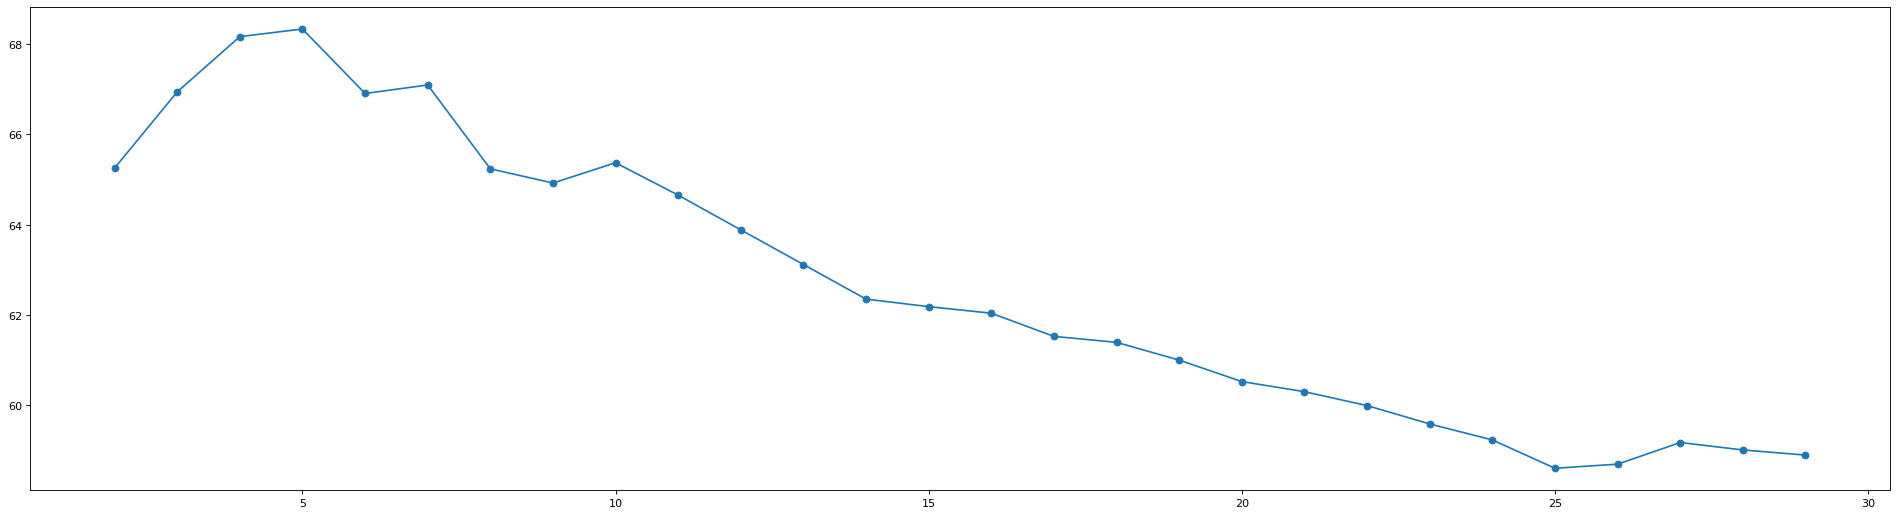

In [29]:
errors = []
for k in range(2, 30):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    errors.append(100*((
        knn.fit(x_train, y_train).score(x_test, y_test))))
figure(figsize=(30, 8), dpi=80)
plt.pyplot.plot(range(2, 30), errors, 'o-')

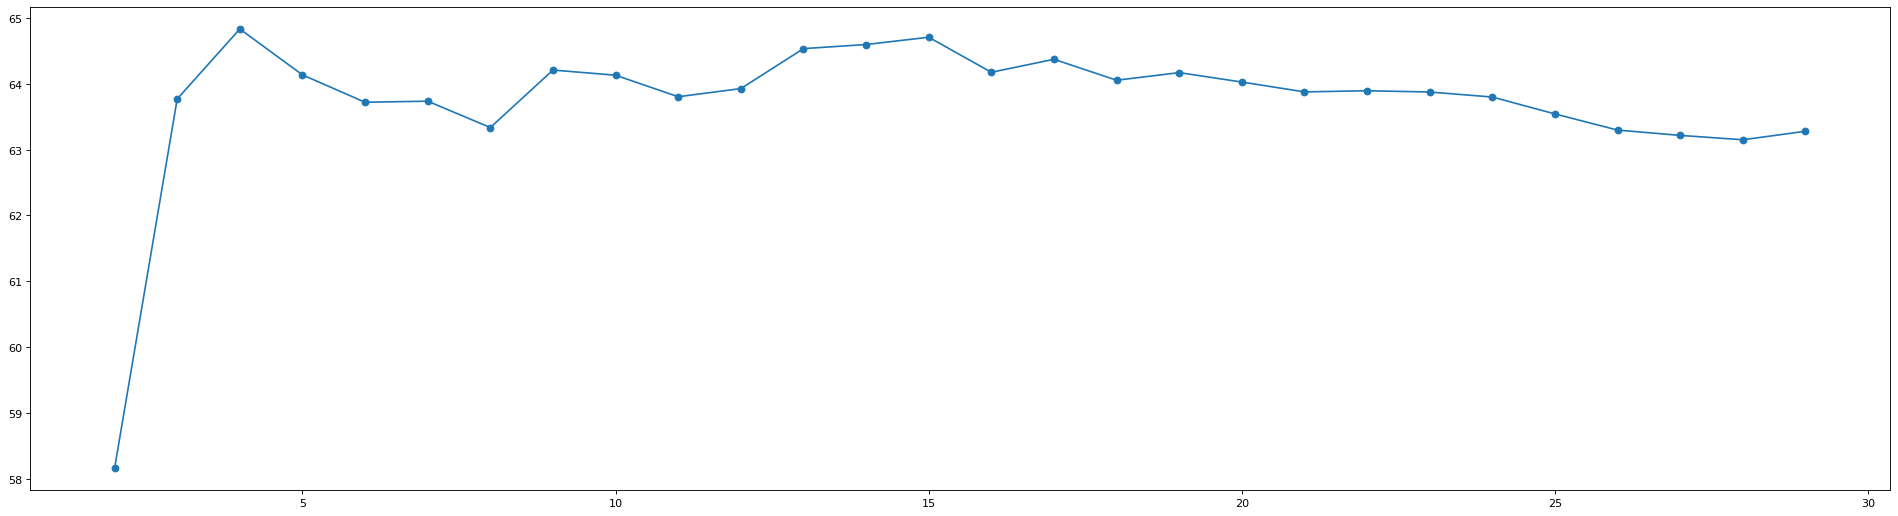

In [30]:
errors = []
for k in range(2, 30):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    errors.append(100*((
        knn.fit(x_train_scaled, y_train).score(x_test_scaled, y_test))))
figure(figsize=(30, 8), dpi=80)
plt.pyplot.plot(range(2, 30), errors, 'o-')

### Random Forrest Regressor 

In [31]:
rdm = RandomForestRegressor(n_estimators=10000)
rdm.fit(x_train_scaled, y_train)
rdm.score(x_test_scaled, y_test)

<ipython-input-31-4efc97a55c20>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rdm.fit(x_train_scaled, y_train)


0.8606299724827378

In [32]:
rdm = RandomForestRegressor(n_estimators=10000)
rdm.fit(x_train, y_train)
rdm.score(x_test, y_test)

<ipython-input-32-4b9406f22822>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rdm.fit(x_train, y_train)


0.8634044498691644

## SVR

In [33]:
regr_SVR = SVR(C=1.0, epsilon=0.2)
regr_SVR.fit(x_train_scaled, y_train)
regr_SVR.score(x_test_scaled, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-0.05411987878946234

In [34]:
regr_SVR = SVR(C=1.0, epsilon=0.2)
regr_SVR.fit(x_train, y_train)
regr_SVR.score(x_test, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-0.054320481529529285

## GBoost

In [35]:
est = GradientBoostingRegressor(
    n_estimators=10000, learning_rate=0.1, max_depth=1, random_state=0)
est.fit(x_train_scaled, y_train)
est.score(x_test_scaled, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8669428986544013

In [36]:
est.fit(x_train, y_train)
est.score(x_test, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8634224541810251

## SGD EGRESSO 

In [37]:
reg_sgd = SGDRegressor(max_iter=1000, tol=1e-3)
reg_sgd.fit(x_train, y_train)
reg_sgd.score(x_test, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-1.525244854437012e+22

In [38]:
reg_sgd.fit(x_train_scaled, y_train)
reg_sgd.score(x_test_scaled, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-33.73954476010852

## MLP

In [39]:
regr_mlp = MLPRegressor(random_state=1, max_iter=500)
regr_mlp.fit(x_train_scaled, y_train)
regr_mlp.score(x_test_scaled, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


-3.738601115322653

In [40]:
regr_mlp.fit(x_train, y_train)
regr_mlp.score(x_test, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.5411978762786802

### Grid Search

In [41]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {
    "learning_rate":[
        0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'r2'
# Créer un regresseur forets aleatoires avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    ensemble.GradientBoostingRegressor(
        random_state=0), # un regression forrets aléatoires
    parameters,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

ValueError: too many values to unpack (expected 3)

In [ ]:

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(x_train , y_train.values.ravel())


In [ ]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_score_)
print(clf.best_params_)

In [42]:
regressor = GradientBoostingRegressor(n_estimators=6000)
regressor.fit(x_train, y_train.values.ravel())
regressor.score(x_test, y_test.values.ravel())

0.8926836702662162

In [43]:
regressor.fit(x_train_scaled, y_train.values.ravel())
regressor.score(x_test_scaled, y_test.values.ravel())

0.8922376646384926

# Feature engineering

## spreads

In [44]:
x_data_final['spread_YrSold_YearBuilt'] = (x_data_final['YrSold'] -
                                           x_data_final['YearBuilt'])
x_data_final['spread_YearRemodAdd_YearBuilt'] = (x_data_final['YearRemodAdd'] -
                                                 x_data_final['YearBuilt'])
x_data_final['spread_YrSold_YearRemodAdd'] = (x_data_final['YrSold'] -
                                              x_data_final['YearRemodAdd'])

## sums

In [45]:
x_data_final['sum_BsmtFinSF1_BsmtFinSF2'] = (x_data_final['BsmtFinSF1'] +
                                             x_data_final['BsmtFinSF2'])
x_data_final['sum_floor'] = (x_data_final['1stFlrSF'] +
                             x_data_final['LowQualFinSF'])
x_data_final['sum_BsmtFullBath_BsmtHalfBath'] = (x_data_final['BsmtFullBath'] +
                                                 x_data_final['BsmtHalfBath'])
x_data_final['sum_FullBath_HalfBath'] = (x_data_final['FullBath'] +
                                         x_data_final['HalfBath'])
x_data_final['TotBsmtBaths'] = (0 +
                                x_data_final['sum_BsmtFullBath_BsmtHalfBath'] +
                                x_data_final['sum_FullBath_HalfBath'])
x_data_final['sum_WoodDeckSF_OpenPorchSF'] = (
                                              x_data_final['WoodDeckSF'] +
                                              x_data_final['OpenPorchSF'])

x_data_final['sum_OCPORCH'] = (
                                                 x_data_final['OpenPorchSF'] +
                                                 x_data_final['EnclosedPorch'])
x_data_final['sum_OpenPorchSF_EnclosedPorch'] = (
                                                 x_data_final['OpenPorchSF'] +
                                                 x_data_final['EnclosedPorch'])

In [46]:
x_data_final['TotAllTypePORCH'] = (x_data_final['OpenPorchSF'] +
                                   x_data_final['EnclosedPorch'] +
                                   x_data_final['3SsnPorch'] +
                                   x_data_final['ScreenPorch'])

## ,percent

In [47]:
x_data_final['%_BsmtFinSF1_TotalBsmtSF'] = (x_data_final['BsmtFinSF1'] /
                                            x_data_final['TotalBsmtSF'])
x_data_final['%_BsmtFinSF2_TotalBsmtSF'] = (x_data_final['BsmtFinSF2'] /
                                            x_data_final['TotalBsmtSF'])
x_data_final['%_BsmtUnfSF_TotalBsmtSF'] = (x_data_final['BsmtUnfSF'] /
                                           x_data_final['TotalBsmtSF'])
x_data_final['%_TotalBsmtSF_LotArea'] = (x_data_final['TotalBsmtSF'] /
                                         x_data_final['LotArea'])
x_data_final['%_GrLivArea_LotArea'] = (x_data_final['GrLivArea'] /
                                       x_data_final['LotArea'])
x_data_final['%_Bedroom_TotRms'] = (
                                    x_data_final['BedroomAbvGr'] /
                                    x_data_final['TotRmsAbvGrd'])
x_data_final['%_KitchenAbvGr_TotRmsAbvGrd'] = (
                                               x_data_final['KitchenAbvGr'] /
                                               x_data_final['TotRmsAbvGrd'])
x_data_final['%_KitchenAbvGr_BedroomAbvGr'] = (
                                               x_data_final['KitchenAbvGr'] /
                                               x_data_final['BedroomAbvGr'])
x_data_final['%_LowQualFinSF_sum_1stFlrSF'] = (
                                               x_data_final['LowQualFinSF'] /
                                               x_data_final['1stFlrSF'])
x_data_final['%_Fireplaces_TotRms'] = (
                                       x_data_final['Fireplaces'] /
                                       x_data_final['TotRmsAbvGrd'])
x_data_final['%_OpenPorch_TotAllTypePORCH'] = (
                                               x_data_final['OpenPorchSF'] /
                                               x_data_final['TotAllTypePORCH'])
x_data_final['%_EnclosedP_TotAllTypePORCH'] = (
                                               x_data_final['EnclosedPorch'] /
                                               x_data_final['TotAllTypePORCH'])
x_data_final['%_3SsnPorch_TotAllTypePORCH'] = (
                                               x_data_final['3SsnPorch'] /
                                               x_data_final['TotAllTypePORCH'])
x_data_final['%_ScreenPo_TotAllTypePORCH'] = (
                                              x_data_final['ScreenPorch'] /
                                              x_data_final['TotAllTypePORCH'])
x_data_final['%_GrLivArea_sum_1stFlr_LowQualFi'] = (
                                                    x_data_final['GrLivArea'] /
                                                    x_data_final['sum_floor'])
x_data_final['%_OpenPorchSF_sum_OCPORCH'] = (
                                             x_data_final['OpenPorchSF'] /
                                             x_data_final['sum_OCPORCH'])
x_data_final['%_EnclosedPorch_sum_OCPORCH'] = (
                                               x_data_final['EnclosedPorch'] /
                                               x_data_final['sum_OCPORCH'])
x_data_final['%_3SsnPorch_sum_sum_OCPORCH'] = (
                                               x_data_final['3SsnPorch'] /
                                               x_data_final['sum_OCPORCH'])
x_data_final['%_ScreenPorch_sum_sum_OCPORCH'] = (
                                                 x_data_final['ScreenPorch'] /
                                                 x_data_final['sum_OCPORCH'])

In [48]:
x_data_final

,FullBath,PoolArea,ScreenPorch,3SsnPorch,EnclosedPorch,OpenPorchSF,WoodDeckSF,GarageArea,GarageCars,Fireplaces,...,%_Fireplaces_TotRms,%_OpenPorch_TotAllTypePORCH,%_EnclosedP_TotAllTypePORCH,%_3SsnPorch_TotAllTypePORCH,%_ScreenPo_TotAllTypePORCH,%_GrLivArea_sum_1stFlr_LowQualFi,%_OpenPorchSF_sum_OCPORCH,%_EnclosedPorch_sum_OCPORCH,%_3SsnPorch_sum_sum_OCPORCH,%_ScreenPorch_sum_sum_OCPORCH
Id,,,,,,,,,,,,,,,,,,,,,
1,2,0,0,0,0,61,0,548,2,0,...,0.000000,1.000000,0.000000,0.0,0.0,1.997664,1.000000,0.000000,0.0,0.0
2,2,0,0,0,0,0,298,460,2,1,...,0.166667,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
3,2,0,0,0,0,42,0,608,2,1,...,0.166667,1.000000,0.000000,0.0,0.0,1.941304,1.000000,0.000000,0.0,0.0
4,1,0,0,0,272,35,0,642,3,1,...,0.142857,0.114007,0.885993,0.0,0.0,1.786681,0.114007,0.885993,0.0,0.0
5,2,0,0,0,0,84,192,836,3,1,...,0.111111,1.000000,0.000000,0.0,0.0,1.919651,1.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2,0,0,0,0,40,0,460,2,1,...,0.142857,1.000000,0.000000,0.0,0.0,1.728227,1.000000,0.000000,0.0,0.0
1457,2,0,0,0,0,0,349,500,2,2,...,0.285714,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
1458,2,0,0,0,0,60,0,252,1,2,...,0.222222,1.000000,0.000000,0.0,0.0,1.969697,1.000000,0.000000,0.0,0.0


In [49]:
x_data_final = x_data_final.fillna(0)
x_data_final.replace(np.inf, 0, inplace=True)
x_data_final.describe()

,FullBath,PoolArea,ScreenPorch,3SsnPorch,EnclosedPorch,OpenPorchSF,WoodDeckSF,GarageArea,GarageCars,Fireplaces,...,%_Fireplaces_TotRms,%_OpenPorch_TotAllTypePORCH,%_EnclosedP_TotAllTypePORCH,%_3SsnPorch_TotAllTypePORCH,%_ScreenPo_TotAllTypePORCH,%_GrLivArea_sum_1stFlr_LowQualFi,%_OpenPorchSF_sum_OCPORCH,%_EnclosedPorch_sum_OCPORCH,%_3SsnPorch_sum_sum_OCPORCH,%_ScreenPorch_sum_sum_OCPORCH
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1.565068,2.758904,15.060959,3.409589,21.954110,46.660274,94.244521,472.980137,1.767123,0.613014,...,0.091567,0.483553,0.124534,0.013535,0.064680,1.356483,0.521354,0.127276,0.044532,0.162339
std,0.550916,40.177307,55.757415,29.317331,61.119149,66.256028,125.338794,213.804841,0.747315,0.644666,...,0.100467,0.481390,0.315828,0.106714,0.227132,0.444028,0.491343,0.320711,0.563486,0.996459
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.500000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,480.000000,2.000000,1.000000,...,0.105556,0.291935,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,0.000000,0.000000,68.000000,168.000000,576.000000,2.000000,1.000000,...,0.166667,1.000000,0.000000,0.000000,0.000000,1.783578,1.000000,0.000000,0.000000,0.000000
max,3.000000,738.000000,480.000000,508.000000,552.000000,547.000000,857.000000,1418.000000,4.000000,3.000000,...,0.500000,1.000000,1.000000,1.000000,1.000000,3.882828,1.000000,1.000000,14.941176,19.800000


# Model Training

In [50]:
features_v2 = x_data_final.columns.to_numpy()
target = ['SalePrice']
# Separating out the features
x = x_data_final.loc[:, features_v2]
# Separating out the target
y = data_final.loc[:, target]

In [51]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.75, random_state=0)
x_train_scaled = StandardScaler().fit_transform(x_train)
x_test_scaled = StandardScaler().fit_transform(x_test)

## Linear Reression 

In [52]:
regr_s = linear_model.LinearRegression()
regr_s.fit(x_train, y_train)
regr_s.score(x_test, y_test)

0.5113548685526544

## Regression ridge

In [53]:
lrr = Ridge(alpha=0.1, max_iter=10000)
alphas = np.logspace(-6, 6, 200)

In [54]:
lrr.fit(x_train_scaled, y_train)
lrr.score(x_test_scaled, y_test)

0.6396227223910383

In [55]:
lrr.fit(x_train, y_train)
lrr.score(x_test, y_test)

0.5541427699939523

## Regression Lasso

In [56]:
from sklearn import linear_model
lrl = linear_model.Lasso(alpha=0.1, max_iter=10000)

In [57]:
lrl.fit(x_train, y_train)
lrl.score(x_test, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 234639598072.31973, tolerance: 679805682.3059437
  model = cd_fast.enet_coordinate_descent(


0.535504527230569

In [58]:
lrl.fit(x_train_scaled, y_train)
lrl.score(x_test_scaled, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140039318514.12054, tolerance: 679805682.3059437
  model = cd_fast.enet_coordinate_descent(


0.6408067883261918

## KNN Regressor

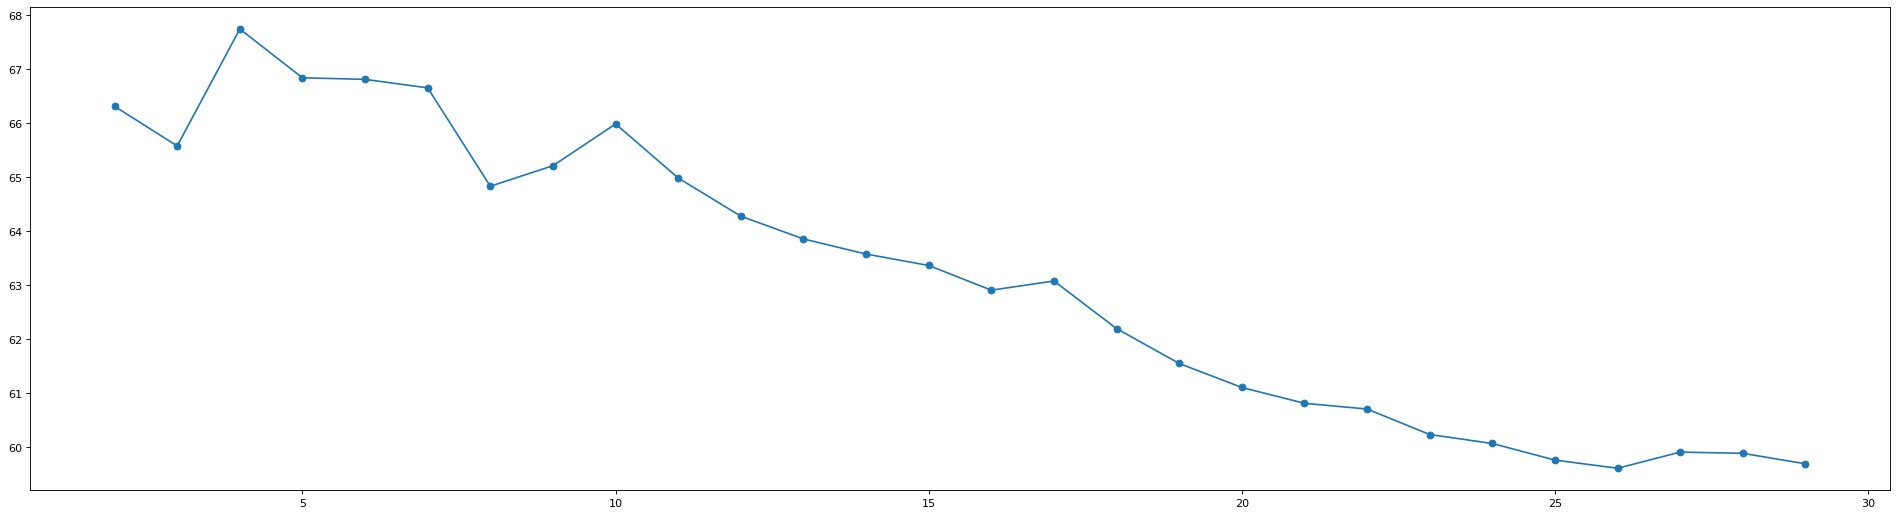

In [59]:
errors = []
for k in range(2, 30):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    errors.append(100*((
        knn.fit(x_train, y_train).score(x_test, y_test))))
figure(figsize=(30, 8), dpi=80)
plt.pyplot.plot(range(2, 30), errors, 'o-')

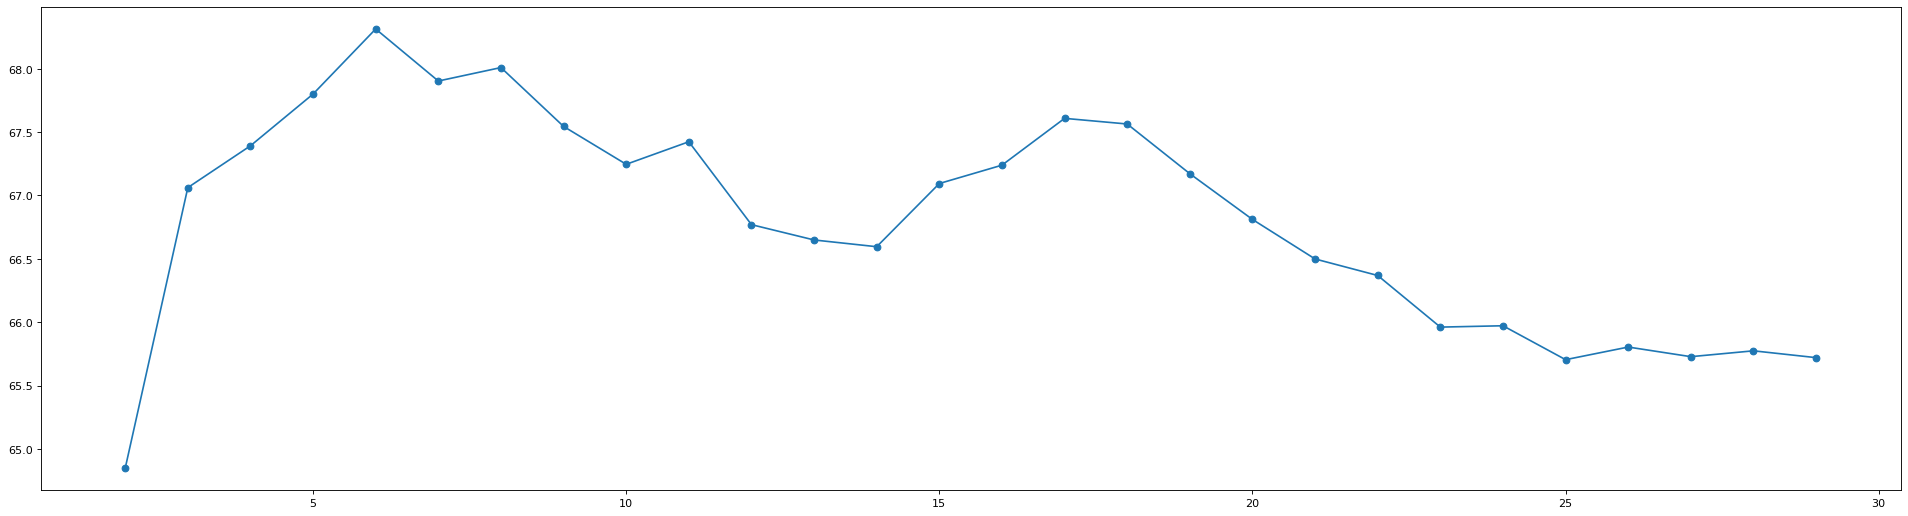

In [60]:
errors = []
for k in range(2, 30):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    errors.append(100*((knn.fit(
        x_train_scaled, y_train).score(x_test_scaled, y_test))))
figure(figsize=(30, 8), dpi=80)
plt.pyplot.plot(range(2, 30), errors, 'o-')

### Random Forrest Regressor 

In [61]:
rdm = RandomForestRegressor(n_estimators=10000)
rdm.fit(x_train_scaled, y_train)
rdm.score(x_test_scaled, y_test)

<ipython-input-61-4efc97a55c20>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rdm.fit(x_train_scaled, y_train)


0.8606775187368273

In [62]:
rdm = RandomForestRegressor(n_estimators=10000)
rdm.fit(x_train, y_train)
rdm.score(x_test, y_test)

<ipython-input-62-4b9406f22822>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rdm.fit(x_train, y_train)


0.8620505637759768

## SVR

In [63]:
regr_SVR = SVR(C=1.0, epsilon=0.2)
regr_SVR.fit(x_train_scaled, y_train)
regr_SVR.score(x_test_scaled, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-0.0540548379205974

In [64]:
regr_SVR = SVR(C=1.0, epsilon=0.2)
regr_SVR.fit(x_train, y_train)
regr_SVR.score(x_test, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-0.05431370083238396

## GBoost

In [65]:
est = GradientBoostingRegressor(n_estimators=10000, learning_rate=0.1, max_depth=1, random_state=0)
est.fit(x_train_scaled, y_train)
est.score(x_test_scaled, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8877801138043264

1:80: E501 line too long (99 > 79 characters)


In [66]:
est.fit(x_train, y_train)
est.score(x_test, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8824846041262995

## SGD EGRESSO 

In [67]:
reg_sgd = SGDRegressor(max_iter=1000, tol=1e-3)
reg_sgd.fit(x_train, y_train)
reg_sgd.score(x_test, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-5.454698838032653e+23

In [68]:
reg_sgd.fit(x_train_scaled, y_train)
reg_sgd.score(x_test_scaled, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-52.66751338014591

## MLP

In [69]:
regr_mlp = MLPRegressor(random_state=1, max_iter=500)
regr_mlp.fit(x_train_scaled, y_train)
regr_mlp.score(x_test_scaled, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


-3.4427224625907717

In [70]:
regr_mlp.fit(x_train, y_train)
regr_mlp.score(x_test, y_test)

C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\morgan\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.5434601302354002

### Grid Search

In [ ]:
from sklearn import neighbors, metrics
from sklearn import model_selection
from sklearn import ensemble

# Fixer les valeurs des hyperparamètres à tester
parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'r2'

# Créer un regresseur forets aleatoires avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    ensemble.GradientBoostingRegressor(random_state = 0), # un regression forrets aléatoires
    parameters,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)


In [ ]:

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(x_train , y_train.values.ravel())


In [ ]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_score_)
print(clf.best_params_)

In [71]:
regressor = GradientBoostingRegressor(n_estimators=10000)
regressor.fit(x_train, y_train.values.ravel())
regressor.score(x_test, y_test.values.ravel())

0.9108200158808544

In [72]:
regressor.fit(x_train_scaled, y_train.values.ravel())
regressor.score(x_test_scaled, y_test.values.ravel())

0.9093112283993074

# Test data